In [410]:
from skimage.io import imread
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
import imutils
import warnings
warnings.filterwarnings('ignore')

In [455]:
car_image = imread("./assets/example/car27.jpg", as_gray=True)
print(car_image.shape)

(645, 860)


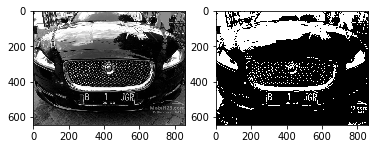

In [456]:
gray_car_image = car_image * 255
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(gray_car_image, cmap="gray")
threshold_value = threshold_otsu(gray_car_image)
binary_car_image = gray_car_image > threshold_value
ax2.imshow(binary_car_image, cmap="gray")
plt.show()

In [457]:
from skimage import measure
from skimage.measure import regionprops
import matplotlib.patches as patches

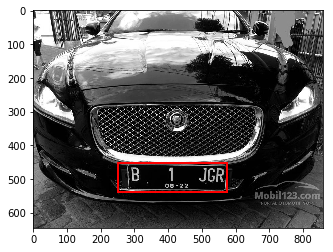

In [458]:
label_image = measure.label(binary_car_image)

plate_objects_cordinates = list()
plate_like_objects = list()

fig, (ax1) = plt.subplots(1)
ax1.imshow(gray_car_image, cmap="gray")

for region in regionprops(label_image):
    if region.area < 50:
        continue

    plate_dimensions = [
        (0.03*label_image.shape[0], 0.08*label_image.shape[0], 0.15*label_image.shape[1], 0.3*label_image.shape[1]),
        (0.08*label_image.shape[0], 0.2*label_image.shape[0], 0.15*label_image.shape[1], 0.4*label_image.shape[1])
    ]
    
    min_row, min_col, max_row, max_col = region.bbox
    
    region_height = max_row - min_row
    region_width = max_col - min_col
    
    for dimension in plate_dimensions:
        min_height, max_height, min_width, max_width = dimension
    
        if region_height >= min_height and region_height <= max_height and region_width >= min_width and region_width <= max_width and region_width > region_height:
            plate_like_objects.append(binary_car_image[min_row:max_row,min_col:max_col])
            plate_objects_cordinates.append((min_row, min_col,max_row, max_col))
            rectBorder = patches.Rectangle((min_col, min_row), max_col - min_col, max_row - min_row, edgecolor="red",
                                           linewidth=2, fill=False)
            ax1.add_patch(rectBorder)
            
plt.show()

In [459]:
import numpy as np
from skimage.transform import resize

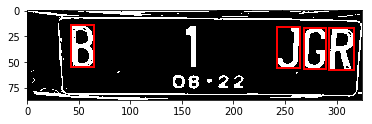

In [460]:
for i in range(len(plate_like_objects)):
    license_plate = plate_like_objects[i]
    
    labelled_plate = measure.label(license_plate)

    fig, ax1 = plt.subplots(1)
    ax1.imshow(license_plate, cmap="gray")

    character_dimensions = (0.35*license_plate.shape[0], 0.60*license_plate.shape[0], 0.05*license_plate.shape[1], 0.15*license_plate.shape[1])
    
    min_height, max_height, min_width, max_width = character_dimensions

    characters = []
    counter=0
    column_list = []
    detected = False
    
    
    for regions in regionprops(labelled_plate):
        y0, x0, y1, x1 = regions.bbox
        region_height = y1 - y0
        region_width = x1 - x0

        if region_height > min_height and region_height < max_height and region_width > min_width and region_width < max_width:
            roi = license_plate[y0:y1, x0:x1]

            # draw a red bordered rectangle over the character.
            rect_border = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor="red",linewidth=2, fill=False)
            ax1.add_patch(rect_border)

            # resize the characters to 20X20 and then append each character into the characters list
            resized_char = resize(roi, (20, 20))
            characters.append(resized_char)

            # this is just to keep track of the arrangement of the characters
            column_list.append(x0)
            
            detected = True
    
    if not detected:
        fig.delaxes(ax1)

In [449]:
import os
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib

In [464]:
letters = [
            '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D',
            'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T',
            'U', 'V', 'W', 'X', 'Y', 'Z'
        ]


def read_training_data(training_directory):
    image_data = []
    target_data = []
    for each_letter in letters:
        for image in os.listdir(os.path.join(training_directory, each_letter)):
            image_path = os.path.join(training_directory, each_letter, image)
            img_details = imread(image_path, as_gray=True)
            binary_image = img_details < threshold_otsu(img_details)
            flat_bin_image = binary_image.reshape(-1)
            if flat_bin_image.shape[0] == 400:
                image_data.append(flat_bin_image)
                target_data.append(each_letter)

    return (np.array(image_data), np.array(target_data))

def cross_validation(model, num_of_fold, train_data, train_label):
    accuracy_result = cross_val_score(model, train_data, train_label, cv=num_of_fold)
    print("Cross Validation Result for ", str(num_of_fold), " -fold")

    print(accuracy_result * 100)


print('reading data')
training_dataset_dir = './characters'
image_data, target_data = read_training_data(training_dataset_dir)

print('reading data completed')

svc_model = SVC(C=1000,kernel='linear', probability=True)

cross_validation(svc_model,4, image_data, target_data)

print('training model')

svc_model.fit(image_data, target_data)

print("model trained.saving model..")
filename = './predict_model.sav'
pickle.dump(svc_model, open(filename, 'wb'))
print("model saved")

reading data
reading data completed
Cross Validation Result for  4  -fold
[79.81651376 98.13084112 92.55319149 91.13924051]
training model
model trained.saving model..
model saved


In [470]:
import pickle
print("Loading model")
filename = './predict_model.sav'
model = pickle.load(open(filename, 'rb'))

print('Model loaded. Predicting characters of number plate')
classification_result = []
for each_character in characters:
    # converts it to a 1D array
    each_character = each_character.reshape(1, -1);
    result = model.predict(each_character)
    #print(each_character)
    classification_result.append(result)

print('Classification result')
print(classification_result)

plate_string = ''
for eachPredict in classification_result:
    plate_string += eachPredict[0]

print('Predicted license plate')
print(plate_string)

column_list_copy = column_list[:]
column_list.sort()
rightplate_string = ''
for each in column_list:
    rightplate_string += plate_string[column_list_copy.index(each)]

print('License plate')
print(rightplate_string)

Loading model
Model loaded. Predicting characters of number plate
Classification result
[array(['B'], dtype='<U1'), array(['J'], dtype='<U1'), array(['G'], dtype='<U1'), array(['R'], dtype='<U1')]
Predicted license plate
BJGR
License plate
BJGR
